In [1]:
import pandas as pd
import numpy as np
import collections
from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from local_helpers.clustering import get_topic_cluster_mapping, get_top_words, gen_nmf_tfidf_model
from local_helpers.clustering import update_default_dict, print_dict_items
%matplotlib inline

In [2]:
df = pd.read_csv('data/articles_categs.csv', index_col = 0)
df.head()

,years,text_final,categ
0,1981 - 1984,Senate Republican leader tell White House offi...,politics
1,1981 - 1984,House Senate conferee today kill Senate - appr...,politics
2,1981 - 1984,"Senator Bob Dole , chairman tax - write Senate...",politics
3,1981 - 1984,1981 tax act draw fire provision allow company...,politics
4,1981 - 1984,Reagan Administration today forward 20-year_PO...,politics


In [3]:
def print_duplicate_keywords(keywords):
    for key in keywords:
        counter=collections.Counter(keywords[key])
        print (key, [word for word in counter if counter[word]>1])

### Clustering of Articles on an Annual Basis

In [4]:
#initialize variables to be used to store analysis
intervals = [(i,i+3) for i in range(1981, 2016, 4)]
final_article_df = pd.DataFrame()
final_topic_df = pd.DataFrame()
interval_outputs = {}

In [5]:
def text_score_multiply(score_text_tuple, multiple):
    final_text = []
    for score, word in score_text_tuple:
        final_text.append((int(round(score*multiple,0))*(word+' '))[:-1])
    return ' '.join(final_text)

In [6]:
df['categ'].unique()

array(['politics', 'NAP', 'culture', 'business', 'sport',
       'foreign affairs', 'medicine'], dtype=object)

### Extract Subclusters for Politics

In [7]:
curr_topic = 'politics'
for i in intervals:
    print(i)
    #initialize articles df for analysis
    curr_df = df[(df['years'].str[:4]==str(i[0]))
                 &(df['categ']==curr_topic)]
    #initialize tfidf object to be used
    tfidf  = TfidfVectorizer(max_df=0.80, min_df=2, max_features= 2000)
    #generate and fit nmf, and tfidf objects, place each article in a cluster
    curr = gen_nmf_tfidf_model(curr_df['text_final'], tfidf_vectorizer=tfidf, n_topics=8)
    #add year to 'articles' df
    curr['article_topic_df']['years'] = (
        np.full(
            (curr['article_topic_df'].shape[0],1),
            f'{i[0]} - {i[1]}'))
    # get the top words for each cluster
    top_30words = get_top_words(nmf_obj=curr['nmf'], tfidf_vectorizer=curr['tfidf_vectorizer'],n_top_words=30)
    #create topic text weighted by topic-word match strength 
    topics = (
        pd.DataFrame({i: [text_score_multiply(top_30words[i], 5)] for i in top_30words}).T
        .rename(columns={0:'topic_words_weighted'}))
    #add year to 'topics' df
    topics['years'] = np.full((topics.shape[0],1),f'{i[0]} - {i[1]}')
    words_only = []
    for i in range(len(top_30words.keys())):
        words_only.append(' '.join([word for score, word in top_30words[i]]))
    topics['words_only'] = words_only
    topics = topics.reset_index().rename(columns={'index':'cluster'})
    #save all outputs to their appropriate data structures
    interval_outputs[i] = curr
    final_topic_df = (final_topic_df
                      .append(topics)
                      .reset_index(drop=True))

    final_article_df = (final_article_df
                        .append(curr['article_topic_df'])
                        .reset_index(drop=True))

(1981, 1984)
(1985, 1988)
(1989, 1992)
(1993, 1996)
(1997, 2000)
(2001, 2004)
(2005, 2008)
(2009, 2012)
(2013, 2016)


In [8]:
pd.options.display.max_colwidth = 200
final_topic_df[['cluster','words_only']]

,cluster,words_only
0,0,state county company new plant million york agency commission 000 water authority official service jersey department new_pos_adj cost hospital board area plan governor federal work system people r...
1,1,reagan budget billion president cut spending deficit house administration program white congress economic_pos_adj military_pos_adj fiscal_pos_adj increase reduction official economy inflation perc...
2,2,mondale hart jackson campaign delegate reagan candidate ferraro convention primary poll party democratic_pos_adj voter president vice presidential_pos_adj nomination percent walter caucus mrs poli...
3,3,vote bill senate party senator house democrats committee democratic_pos_adj election republican_pos_adj republican republicans candidate democrat leader campaign district governor representative a...
4,4,a1 page reagan b1 d1 accord new metropolitan official column b3 york soviet_pos_adj american_pos_adj president minister national united digest military_pos_adj union states government administrati...
5,5,tax income taxis percent increase revenue rate bill cut deduction treasury state million business pay sale taxpayer credit deficit benefit investment proposal billion raise interest provision budg...
6,6,court judge case justice law lawyer supreme trial defendant decision attorney appeal ruling charge jury federal district right police rule crime sentence state school department woman appeals pris...
7,7,city mayor koch police council board york yesterday million new building housing budget street hall officer rent manhattan fiscal_pos_adj plan brooklyn school tenant commissioner apartment 000 tra...
8,0,company million government official bank business agency new a1 000 federal department commission work new_pos_adj report investigation firm york contract industry general charge people executive ...
9,1,tax income taxis deduction percent rate taxpayer state revenue plan increase pay proposal cut capital bill business packwood rostenkowski individual investment interest budget gain committee 000 b...


### Generate Clustering of Topics Based on Key Words

Here we take the clusters of topics which were generated on a yearly basis and see if we can cluster the topics.  The advantage of this approach is that we can see different subtopics emerge at different points of time.  We will then use these key words which are generated to label each topic as either `business`, `politics`, `sports`, `foreign affairs`, `medicine`, and `culture`.

In [9]:
tfidf  = TfidfVectorizer(max_df=0.80, min_df=2, max_features= 1000)
topic_output = gen_nmf_tfidf_model(final_topic_df['topic_words_weighted'], n_topics = 8, tfidf_vectorizer=tfidf)
top_30words_topics = get_top_words(topic_output['nmf'], topic_output['tfidf_vectorizer'],n_top_words=30)

In [10]:
for j in top_30words_topics:
    print('------------------------------------')
    print([i[1] for i in top_30words_topics[j]])

------------------------------------
['party', 'democrats', 'republicans', 'vote', 'election', 'senate', 'republican', 'senator', 'candidate', 'democratic_pos_adj', 'republican_pos_adj', 'house', 'voter', 'campaign', 'bill', 'leader', 'committee', 'race', 'governor', 'political_pos_adj', 'seat', 'democrat', 'win', 'state', 'support', 'representative', 'majority', 'district', 'congress', 'white']
------------------------------------
['court', 'judge', 'case', 'justice', 'lawyer', 'trial', 'law', 'jury', 'prosecutor', 'supreme', 'defendant', 'decision', 'ruling', 'charge', 'sentence', 'attorney', 'appeal', 'juror', 'defense', 'legal_pos_adj', 'prison', 'federal', 'evidence', 'federal_pos_adj', 'rule', 'state', 'right', 'witness', 'murder', 'death']
------------------------------------
['mayor', 'city', 'giuliani', 'koch', 'bloomberg', 'council', 'dinkins', 'hall', 'yesterday', 'york', 'ferrer', 'new', 'board', 'budget', 'housing', 'commissioner', 'union', 'administration', 'mayoral_pos_a

In [11]:
key_words = {'congressional_politics': ['tax', 'income', 'taxis', 'cut', 'budget', 'rate', 'spending', 
                                 'revenue', 'percent', 'deficit', 'proposal', 'deduction', 'bill',
                                 'fiscal_pos_adj', 'program', 'debt', 'taxpayer'],
             'elections': ['vote', 'election','candidate', 'democratic_pos_adj', 'republican_pos_adj', 
                           'voter', 'campaign', 'race', 'win', 'majority', 'delegate','primary','nomination',
                          'convention'],
             'justice system': ['court', 'judge', 'case', 'justice', 'lawyer', 'trial', 'law', 
                                'jury', 'prosecutor', 'supreme', 'defendant', 'decision', 'ruling', 
                                'charge', 'sentence', 'attorney', 'appeal', 'juror', 'defense', 'legal_pos_adj', 
                                'prison', 'federal', 'evidence', 'federal_pos_adj', 'witness', 'murder', 'death'],
             'ny state': ['mayor', 'city', 'hall', 'york','new', 'board', 'budget',
                          'housing', 'commissioner', 'union', 'administration', 'mayoral_pos_adj', 'fiscal_pos_adj',
                          'yorkers', 'borough', 'police', 'manhattan', 'brooklyn', 'cuomo', 'building', 'campaign'],
             'crime': ['police', 'officer', 'arrest', 'car', 'man', 'detective', 'shooting', 'shoot', 'drug', 
                       'fire', 'crime', 'department', 'kill', 'suspect', 'street', 'gun', 'charge', 'precinct', 
                       'murder', 'death', 'investigator', 'yesterday', 'official', 'black_pos_adj', 'report', 
                       'night', 'incident', 'people', 'white_pos_adj']}

In [12]:
keyword_scores = {}
for key in key_words:
    keyword_scores[key] = (
        final_topic_df['words_only'].str.split(' ')
        .apply(lambda x: len(set(x) & set(key_words[key]))))
    
keyword_scores = pd.DataFrame(keyword_scores).reset_index()

In [13]:
keyword_words = {}
for key in key_words:
    keyword_words[key] = (
        final_topic_df['words_only'].str.split(' ')
        .apply(lambda x: set(x) & set(key_words[key])))
    
keyword_words = pd.DataFrame(keyword_words).reset_index()

In [14]:
max_scores = (
    pd.melt(keyword_scores, id_vars='index')
    .groupby('index').max()
    .reset_index()[['index','value']]
    .set_index(['index','value']))

all_scores = (
    pd.melt(keyword_scores, id_vars='index')
    .set_index(['index','value']))

topic_matches = (
    max_scores
    .join(all_scores, on = ['index','value'])
    .reset_index().set_index('index')
    .drop('value',axis=1)
    .rename(columns = {'variable':'count_column'}))

In [15]:
keyword_scores1 = {}
for key in key_words:
    keyword_scores1[key] = (
        final_topic_df['words_only'].str.split(' ')
        .apply(lambda x: int(100* round(len(set(x) & set(key_words[key]))
               /float(len(key_words[key])), 4))))
    
keyword_scores1 = pd.DataFrame(keyword_scores1).reset_index()

In [16]:
max_scores1 = (
    pd.melt(keyword_scores1, id_vars='index')
    .groupby('index').max()
    .reset_index()[['index','value']]
    .set_index(['index','value']))

all_scores1 = (
    pd.melt(keyword_scores1, id_vars='index')
    .set_index(['index','value']))

topic_matches1 = (
    max_scores1
    .join(all_scores1, on = ['index','value'])
    .reset_index().set_index('index')
    .drop('value',axis=1)
    .rename(columns = {'variable':'pct_column'})
)

### Find Rows Where the Percentage and Naive Count Categorizations Match

In [17]:
percent_count_match = (
    topic_matches1.reset_index()['pct_column'].values == 
    topic_matches.reset_index().drop_duplicates('index')['count_column'].values)

In [18]:
keyword_scores[~percent_count_match]

,index,congressional_politics,elections,justice system,ny state,crime
0,0,0,0,1,3,4
8,8,0,0,2,4,5
16,16,1,1,0,1,1
54,54,1,7,0,8,1
70,70,1,1,0,0,1


In [19]:
keyword_scores1[~percent_count_match]

,index,congressional_politics,elections,justice system,ny state,crime
0,0,0,0,3,14,13
8,8,0,0,7,19,17
16,16,5,7,0,4,3
54,54,5,50,0,38,3
70,70,5,7,0,0,3


#### Look below to find words which may not be providing great categorization power

In [20]:
keyword_words[~percent_count_match]

,index,congressional_politics,elections,justice system,ny state,crime
0,0,{},{},{federal},"{new, board, york}","{official, report, people, department}"
8,8,{},{},"{federal, charge}","{new, union, board, york}","{official, report, department, charge, people}"
16,16,{bill},{vote},{},{administration},{official}
54,54,{percent},"{election, vote, campaign, voter, race, democratic_pos_adj, candidate}",{},"{union, mayoral_pos_adj, york, campaign, city, new, mayor, yorkers}",{black_pos_adj}
70,70,{percent},{vote},{},{},{man}


### Use Percentage Match to Find  Best Matches

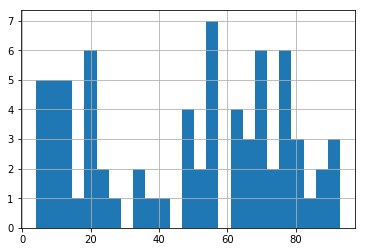

In [21]:
max_scores1.reset_index()['value'].hist(bins=25)
plt.show()

In [22]:
pd.options.display.max_colwidth = 200

In [23]:
keyword_words[max_scores1.reset_index()['value']<50].join(max_scores1.reset_index()['value']).join(final_topic_df['words_only'])

,index,congressional_politics,elections,justice system,ny state,crime,value,words_only
0,0,{},{},{federal},"{new, board, york}","{official, report, people, department}",14,state county company new plant million york agency commission 000 water authority official service jersey department new_pos_adj cost hospital board area plan governor federal work system people r...
4,4,{},{},{},"{union, york, administration, city, police, new}","{official, report, police}",28,a1 page reagan b1 d1 accord new metropolitan official column b3 york soviet_pos_adj american_pos_adj president minister national united digest military_pos_adj union states government administrati...
8,8,{},{},"{federal, charge}","{new, union, board, york}","{official, report, department, charge, people}",19,company million government official bank business agency new a1 000 federal department commission work new_pos_adj report investigation firm york contract industry general charge people executive ...
12,12,"{bill, program, deficit, budget, proposal, cut, spending}",{vote},{},"{administration, budget}",{},41,house budget reagan senate bill president billion deficit congress white spending senator administration vote cut committee program trade military_pos_adj veto increase legislation today proposal ...
16,16,{bill},{vote},{},{administration},{official},7,bush house president white congress administration bill reagan committee senator senate democrats today sununu policy political_pos_adj official loan secretary saving vote bank baker republicans g...
21,21,"{program, percent}",{},{},"{york, city, housing, new, building}","{official, people, department}",23,city new county housing state york company million project 000 jersey official water development department program new_pos_adj plan building plant percent cost agency people build area site autho...
23,23,{program},{},{},"{new, union, board, city}",{},19,school board district education teacher fernandez student chancellor principal superintendent system parent child state member class aid program city local_pos_adj new dr union educational_pos_adj...
24,24,{},{},{lawyer},{board},"{official, people, man}",10,mr company year executive time president know like yeltsin work people man tell day business official office come go ms board firm today friend think take government lawyer chairman leave
25,25,{},{},{},"{cuomo, brooklyn, york, city, new}",{official},23,new york b3 state jersey city b5 b4 b6 a1 pataki b2 school governor region year county whitman island cuomo page official million connecticut authority new_pos_adj chronicle center long brooklyn
26,26,"{tax, bill, program, budget, cut, spending}","{vote, republican_pos_adj}",{},"{administration, budget}",{},35,clinton house bill budget republicans tax senate white president congress cut democrats vote spending senator committee welfare program year billion republican_pos_adj today administration represe...


Use 20% as threshold for each topic.

In [24]:
final_topic_df = (
    final_topic_df
    .join(topic_matches1[max_scores1.reset_index()['value']>20])
    .fillna('NAP'))

In [25]:
final_article_df = (
    final_article_df
    .rename(columns={'categ':'cluster'})
    .set_index(['cluster','years'])
    .join(final_topic_df[['cluster','years','pct_column']]
          .set_index(['cluster','years']))
    .reset_index().drop('cluster',axis=1)
)


In [26]:
total_year_counts = (final_article_df
                     .groupby('years').count()
                     .rename(columns={'pct_column':'total_count'})
                     .drop('text_final',axis=1))

In [27]:
total_year_props = (
    pd.merge(final_article_df
             .groupby(['years','pct_column']).count()
             .reset_index(),
             total_year_counts,
             on = 'years')
    .rename(columns = {'text_final':'article_count'})
)
total_year_props['topic_prop'] = (
    total_year_props['article_count']/total_year_props['total_count'])

In [28]:
total_year_props['final_year'] = total_year_props['years'].str[-5:].astype(int)

In [29]:
cols = {col_type:total_year_props[total_year_props['pct_column']==col_type].set_index('final_year')['article_count'] 
        for col_type in total_year_props['pct_column'].unique()}

categ_ot = pd.DataFrame(cols).fillna(0)

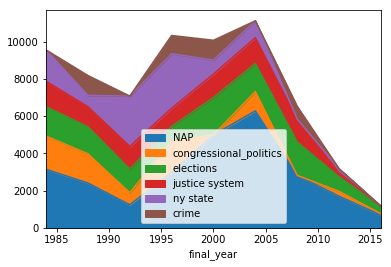

In [30]:
categ_ot.plot.area()

In [32]:
s

In [35]:
df.groupby(['years']).count()

,text_final,categ
years,,
1981 - 1984,30857,30857
1985 - 1988,31300,31300
1989 - 1992,30550,30550
1993 - 1996,30427,30427
1997 - 2000,39398,39398
2001 - 2004,48281,48281
2005 - 2008,38924,38924
2009 - 2012,28127,28127
2013 - 2016,23370,23370


In [38]:
df[df['years']=='2013 - 2016']

,years,text_final,categ
50503,2013 - 2016,"Lovell , Maine — Rosie ’s General Store serve breakfast day , ’s type place resident town 1,140 stop buy lottery ticket , loaf bread special_POS_ADJ jumbo_POS_ADJ lobster roll . ’s inspiration Swe...",culture
50504,2013 - 2016,""" love Designs , "" Anni Kuan say day , exuberance unforced_POS_ADJ curve - graze dress , cocoon coat boot - cut pant lend touch raciness low_POS_ADJ - key design . Ms. Kuan feel game , reason . fa...",culture
50505,2013 - 2016,"June 21 , Gretchen Carlson close minute afternoon Fox News , "" Real Story Gretchen Carlson , "" discussion milestone : turn 50 day.“i know , normally_POS_ADV folk tv not_POS_ADV readily_POS_ADV adm...",culture
50506,2013 - 2016,"killer clown , quick_POS_ADJ dead_POS_ADJ roam New Directors / New Films , annual_POS_ADJ showcase promise confirm cinematic_POS_ADJ talent begin Wednesday . year , series establish present work e...",culture
50507,2013 - 2016,"oh England . ’s yearning stir adaptation , outside Harry Potter book . - mini_POS_ADJ - series , Hbo Wednesday Thursday night , lovely_POS_ADJ old_POS_ADJ village medieval_POS_ADJ abbey , cobble s...",culture
50508,2013 - 2016,""" have fight somebody , "" Tom Wolfe 2004 , “ sure_POS_ADJ alive_POS_ADJ wake morning.”mr . wolfe famous_POS_ADJ bright_POS_ADJ - eyed_POS_ADJ best_POS_ADV - sell book literary_POS_ADJ journalism (...",culture
50509,2013 - 2016,"summer , thumb past Instagram photo familiar_POS_ADV - look young_POS_ADJ man silken_POS_ADJ brown_POS_ADJ skin enviable_POS_ADJ high_POS_ADJ - fade dress azure_POS_ADJ suit . linger moment , slig...",culture
50510,2013 - 2016,""" world wish - grant factory . "" line , "" Fault Stars , "" undoubtedly_POS_ADV true_POS_ADJ , true_POS_ADJ movie , like book , expertly_POS_ADV build machine mass_POS_ADJ production tear . direct J...",culture
50511,2013 - 2016,"November 22 , 1963 , Abraham Zapruder ordinary_POS_ADJ citizen Dallas : 58-year_POS_ADJ - old_POS_ADJ prosperous_POS_ADJ manufacturer woman ’s clothing arrive city Russia way Brooklyn . day unfold...",culture
50512,2013 - 2016,"enter Columbia ’s Graduate School Journalism Upper West New York , academic_POS_ADJ majesty look . past lamp iron claws statue Jefferson ( “ liberty depend freedom press “ ) lie 100-year - old_POS...",culture
